In [1]:
import sys
print(sys.executable)

/home2/mndq73/deeplearning-local/bin/python3.9


In [2]:
# !pip install torch

In [3]:
# !pip install torchvision

In [4]:
# !pip install matplotlib

In [5]:
# !pip install scipy

In [6]:
# !pip install numpy

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import os
import torch.nn.functional as F
from torchvision.models import inception_v3
import matplotlib.pyplot as plt
from scipy import linalg

In [8]:

class InceptionStatistics:
    def __init__(self, device):
        self.model = torchvision.models.inception_v3(weights=torchvision.models.Inception_V3_Weights.IMAGENET1K_V1).to(device)
        self.model.eval()
        # We want to get the features before the final classification layer
        # We'll use the features from the last pooling layer
        self.model.fc = nn.Identity()  # Remove classification layer
        self.model.dropout = nn.Identity()  # Remove dropout

    @torch.no_grad()
    def get_features(self, images):
        # Resize images to inception input size
        images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
        # The inception model expects inputs in range [0, 1]
        if images.min() < 0:
            images = (images + 1) / 2
        # Get features (output will be [batch_size, 2048])
        features = self.model(images)
        return features.cpu().numpy()

def calculate_fid(real_features, fake_features):
    """Calculate Fréchet Distance between two image distributions."""
    # Convert to float64 to prevent numerical instability
    real_features = real_features.astype(np.float64)
    fake_features = fake_features.astype(np.float64)

    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    # Add small epsilon to diagonal for numerical stability
    eps = 1e-6
    sigma1 = sigma1 + np.eye(sigma1.shape[0]) * eps
    sigma2 = sigma2 + np.eye(sigma2.shape[0]) * eps

    # Handle numerical errors in sqrtm
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    if not np.isfinite(covmean).all():
        print("FID calculation produced singular product; adding more epsilon")
        eps = 1e-3
        sigma1 = sigma1 + np.eye(sigma1.shape[0]) * eps
        sigma2 = sigma2 + np.eye(sigma2.shape[0]) * eps
        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    # Ensure FID is non-negative
    return max(fid, 0.0)

In [9]:
# Constants
nz = 256  # Size of latent vector Z
nc = 3    # Number of channels in the image (RGB)
npx = 32  # Image size (32x32)
ngf = 128 # Generator feature maps
ndf = 128 # Discriminator feature maps
# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.Resize(npx),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

test_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# 创建数据加载器
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2)

In [10]:

# Generator
ngf = 128
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Fully connected layer
            nn.Linear(nz, (ngf // 4) * 4 * 4 * 4),
            nn.BatchNorm1d((ngf // 4) * 4 * 4 * 4),
            nn.ReLU(True),

            # Reshape to ((ngf//4)*4, 4, 4)
            nn.Unflatten(1, ((ngf // 4) * 4, 4, 4)),

            # Deconv1: ((ngf//4)*4, 4, 4) -> ((ngf//4)*2, 8, 8)
            nn.ConvTranspose2d((ngf // 4) * 4, (ngf // 4) * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d((ngf // 4) * 2),
            nn.ReLU(True),

            # Deconv2: ((ngf//4)*2, 8, 8) -> (ngf//4, 16, 16)
            nn.ConvTranspose2d((ngf // 4) * 2, ndf // 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf // 4),
            nn.ReLU(True),

            # Deconv3: (ngf//4, 16, 16) -> (nc, 32, 32)
            nn.ConvTranspose2d(ndf // 4, nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


ndf = 128
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Conv1: (nc, 32, 32) -> (ndf//4, 16, 16)
            nn.Conv2d(nc, ndf // 4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # Conv2: (ndf//4, 16, 16) -> (ndf//2, 8, 8)
            nn.Conv2d(ndf // 4, ndf // 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf // 2),
            nn.LeakyReLU(0.2, inplace=True),

            # Conv3: (ndf//2, 8, 8) -> (ndf, 4, 4)
            nn.Conv2d(ndf // 2, ndf, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),

            # Fully connected
            nn.Flatten(),
            nn.Linear(ndf * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
# Weight Initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
# Instantiate models
netG = Generator().to(device)
netD = Discriminator().to(device)

# Initialize weights
netG.apply(weights_init)
netD.apply(weights_init)
# Move fixed noise to device
fixed_noise = torch.randn(64, nz).to(device)
fid_noise = torch.randn(100, nz).to(device)

In [12]:

def save_generated_images(epoch, fixed_noise, netG, save_path='generated_images4'):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()

    # Rescale images from [-1, 1] to [0, 1]
    fake = (fake + 1) / 2.0
    fake = torch.clamp(fake, 0, 1)  # 确保所有像素值在 [0,1] 之间

    # **关键修复点**
    grid = torchvision.utils.make_grid(fake[:64], nrow=8, padding=0, normalize=True)

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Generated Images (Epoch {epoch})")
    plt.imshow(np.transpose(torchvision.utils.make_grid(fake[:64], padding=0, normalize=False), (1,2,0)))
    plt.savefig(f'{save_path}/epoch_{epoch}.png')
    plt.show()
    plt.close()


In [13]:
# Calculate and print total parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'\nTotal Generator parameters: {count_parameters(netG):,}')
print(f'Total Discriminator parameters: {count_parameters(netD):,}\n')

print(f"total parameters: {count_parameters(netG)+count_parameters(netD)}")


Total Generator parameters: 696,099
Total Discriminator parameters: 168,033

total parameters: 864132


In [14]:
# import numpy as np
# print(np.__version__)

FID Score at epoch 1: 251.09
Epoch [1/50] Loss_D: 0.1436, Loss_G: 4.0008, total_steps=782
Epoch [2/50] Loss_D: 0.3259, Loss_G: 3.1952, total_steps=1564
Epoch [3/50] Loss_D: 0.3616, Loss_G: 3.1923, total_steps=2346
Epoch [4/50] Loss_D: 0.3948, Loss_G: 2.9880, total_steps=3128
Epoch [5/50] Loss_D: 0.5247, Loss_G: 2.6008, total_steps=3910
FID Score at epoch 6: 131.66
Epoch [6/50] Loss_D: 0.6048, Loss_G: 2.1633, total_steps=4692
Epoch [7/50] Loss_D: 0.6059, Loss_G: 2.0687, total_steps=5474
Epoch [8/50] Loss_D: 0.5523, Loss_G: 2.0961, total_steps=6256
Epoch [9/50] Loss_D: 0.5094, Loss_G: 2.3313, total_steps=7038
Epoch [10/50] Loss_D: 0.5267, Loss_G: 2.4915, total_steps=7820
FID Score at epoch 11: 133.87
Epoch [11/50] Loss_D: 0.4545, Loss_G: 2.6002, total_steps=8602
Epoch [12/50] Loss_D: 0.4492, Loss_G: 2.4165, total_steps=9384
Epoch [13/50] Loss_D: 0.4017, Loss_G: 2.4586, total_steps=10166
Epoch [14/50] Loss_D: 0.5123, Loss_G: 2.3479, total_steps=10948
Epoch [15/50] Loss_D: 0.5024, Loss_G: 

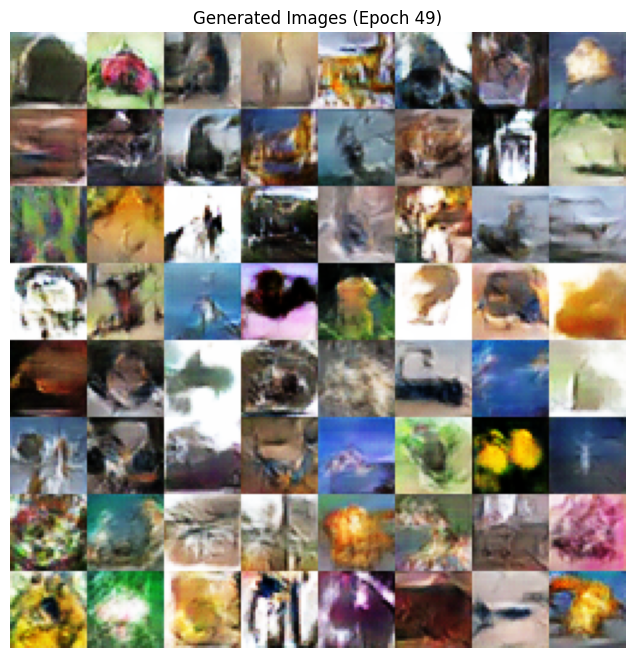

In [15]:

# 定义梯度惩罚函数
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake.detach() * (1 - alpha)
    interpolated_images.requires_grad_(True)

    # 计算判别器输出
    mixed_scores = critic(interpolated_images)

    # 计算梯度
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores).to(device),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

# 其他函数和类定义...

if __name__ == '__main__':
    # Loss and Optimizers
    criterion = nn.BCELoss()
    optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))

    # Labels for real and fake
    real_label = 1
    fake_label = 0

    # Initialize lists to store losses
    G_losses = []
    D_losses = []

    inception = InceptionStatistics(device)
    # Training Loop
# 初始化总步数
total_steps = 0  # 记录全局训练步数
max_steps = 50000  # 训练最大步数

num_epochs = 50  # 仍然设定最大 epoch，但可能提前停止
for epoch in range(num_epochs):
    running_G_loss = 0.0
    running_D_loss = 0.0
    n_batches = 0

    for i, data in enumerate(dataloader, 0):
        if total_steps >= max_steps:  # 当达到 50000 步时停止
            print(f"Reached {max_steps} steps, stopping training.")
            break

        # Train Discriminator
        netD.zero_grad()
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        
        output = netD(real_images).view(-1)
        errD_real = criterion(output, labels)
        errD_real.backward()

        # Train Discriminator with fake data
        noise = torch.randn(batch_size, nz, device=device)
        fake_images = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(output, labels)
        errD_fake.backward()

        # 计算梯度惩罚
        gp = gradient_penalty(netD, real_images, fake_images, device=device)
        gp.backward()

        optimizerD.step()  # 更新判别器
        
        total_steps += 1  # **记录 D 的优化步数**
        if total_steps >= max_steps:
            break  # 达到 50,000 步时，提前停止训练

        # Train Generator
        netG.zero_grad()
        labels.fill_(real_label)
        output = netD(fake_images).view(-1)
        errG = criterion(output, labels)
        errG.backward()
        optimizerG.step()  # 更新生成器
        
        total_steps += 1  # **记录 G 的优化步数**
        if total_steps >= max_steps:
            break  # 达到 50,000 步时，提前停止训练

        # Accumulate losses
        running_G_loss += errG.item()
        running_D_loss += (errD_real + errD_fake).item()
        n_batches += 1


    # Calculate average epoch losses
    epoch_G_loss = running_G_loss / n_batches
    epoch_D_loss = running_D_loss / n_batches

    # Record epoch losses
    G_losses.append(epoch_G_loss)
    D_losses.append(epoch_D_loss)

    # 计算 FID 并输出日志
    if (epoch) % 5 == 0 or epoch == num_epochs - 1:
        real_images = next(iter(dataloader))[0][:100].to(device)
        real_features = inception.get_features(real_images)
        fake_images = netG(fid_noise).detach().to(device)
        fake_features = inception.get_features(fake_images)
        fid_score = calculate_fid(real_features, fake_features)
        print(f"FID Score at epoch {epoch+1}: {fid_score:.2f}")

    # **添加 total_steps 输出**
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss_D: {epoch_D_loss:.4f}, Loss_G: {epoch_G_loss:.4f}, total_steps={total_steps}")

    if epoch == num_epochs - 1:
        save_generated_images(epoch, fixed_noise, netG)


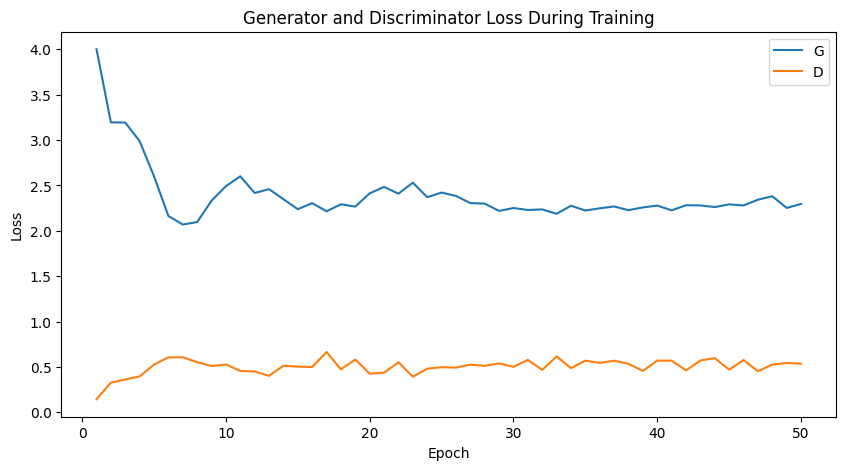

In [21]:
# Plot losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(range(1, num_epochs + 1), G_losses, label="G")
plt.plot(range(1, num_epochs + 1), D_losses, label="D")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss_plot.png')
plt.show()
plt.close()

In [22]:
# Save the trained models
torch.save(netG.state_dict(), 'generator_cifar100.pth')
torch.save(netD.state_dict(), 'discriminator_cifar100.pth')
print("Models saved successfully!")

Models saved successfully!


In [23]:
total_samples = len(test_dataset)
num_samples = 10000
subset, _ = random_split(test_dataset, [num_samples, total_samples - num_samples])
subset_loader = DataLoader(subset, batch_size=64, shuffle=False, num_workers=2)

fake_features_list=[]
for i in range(100):
    final_fid_noise = torch.randn(100, nz).to(device)
    fake_images = netG(final_fid_noise).detach().to(device)
    fake_features = inception.get_features(fake_images)
    fake_features_list.append(fake_features)
fake_features_list = np.concatenate(fake_features_list, axis=0)

features_list = []
for images, labels in subset_loader:
    images = images.to(device)
    real_features = inception.get_features(images)
    features_list.append(real_features)

features_list = np.concatenate(features_list, axis=0)

fid_score = calculate_fid(features_list, fake_features_list)
print(f"Final FID Score: {fid_score:.2f}")


Final FID Score: 33.39


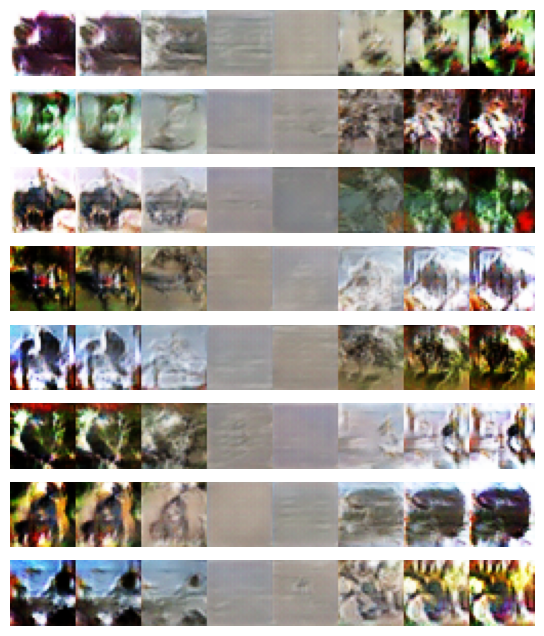

In [24]:
def interpolate_and_generate_images(netG, nz, device, num_pairs=8, num_steps=8):
    noise_pairs = [(torch.randn(1, nz).to(device), torch.randn(1, nz).to(device)) for _ in range(num_pairs)]

    all_images = []

    for noise1, noise2 in noise_pairs:
        interpolated_noises = [noise1 * (1 - alpha) + noise2 * alpha for alpha in torch.linspace(0, 1, num_steps)]

        interpolated_noises = torch.cat(interpolated_noises, dim=0)

        with torch.no_grad():
            fake_images = netG(interpolated_noises).detach().cpu()

        all_images.append(fake_images)

    visualize_generated_images(all_images, num_steps)

def visualize_generated_images(all_images, num_steps):

    plt.figure(figsize=(num_steps, len(all_images)))
    for i, images in enumerate(all_images):
        # 将每组插值的图片拼接为网格
        grid = torchvision.utils.make_grid(images, nrow=num_steps, normalize=True, padding=0)
        plt.subplot(len(all_images), 1, i + 1)
        plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
        plt.axis("off")
    plt.show()


interpolate_and_generate_images(netG, nz, device)

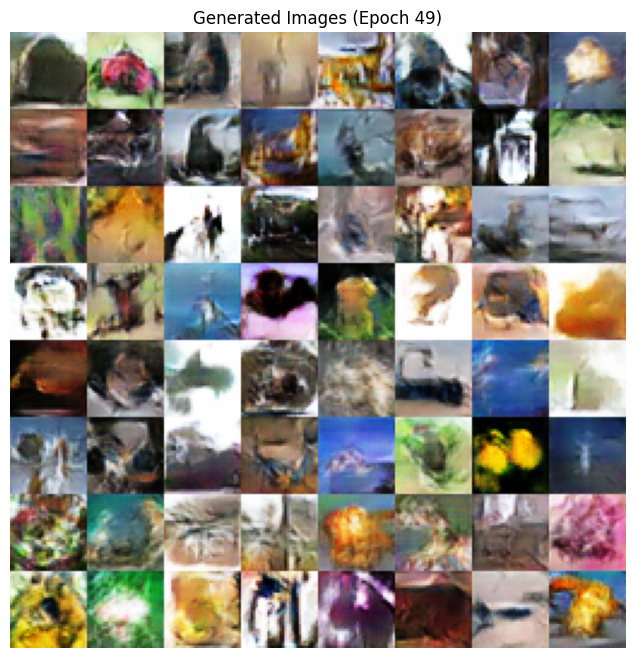

In [25]:
save_generated_images(epoch, fixed_noise, netG)